[View in Colaboratory](https://colab.research.google.com/github/trexwithoutt/Speech-Emotion-Recognition-utterancelevel-DNN/blob/master/SER.ipynb)

In [0]:
!kill -9 -1

In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

gpg: keybox '/tmp/tmpc7fmpwva/pubring.gpg' created
gpg: /tmp/tmpc7fmpwva/trustdb.gpg: trustdb created
gpg: key AD5F235DF639B041: public key "Launchpad PPA for Alessandro Strada" imported
gpg: Total number processed: 1
gpg:               imported: 1
··········


In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
cd drive

/content/drive


In [0]:
ls

datalab/  drive/


In [0]:
pwd

'/content/drive'

In [0]:
!pip3 install tqdm

    100% |████████████████████████████████| 51kB 3.4MB/s 


In [0]:
!pip3 install librosa

    100% |████████████████████████████████| 1.6MB 6.8MB/s 
    100% |████████████████████████████████| 184kB 13.2MB/s 
    100% |████████████████████████████████| 327kB 14.7MB/s 
    100% |████████████████████████████████| 1.9MB 12.7MB/s 
    100% |████████████████████████████████| 15.8MB 2.7MB/s 
  Running setup.py bdist_wheel for librosa ... - \ done
  Stored in directory: /content/.cache/pip/wheels/e7/58/3a/820767c35a26cdb7e9d70971454fc6e072524aa4edc934f710
  Running setup.py bdist_wheel for audioread ... - done
  Stored in directory: /content/.cache/pip/wheels/53/02/90/7b5c4081b7470c550ab605f600bad237dde12a6b8999b11f50
  Running setup.py bdist_wheel for resampy ... - \ done
  Stored in directory: /content/.cache/pip/wheels/ff/4f/ed/2e6c676c23efe5394bb40ade50662e90eb46e29b48324c5f9b
Successfully built librosa audioread resampy


In [0]:
!pip install tflearn

    100% |████████████████████████████████| 102kB 4.6MB/s 
  Running setup.py bdist_wheel for tflearn ... - \ done
  Stored in directory: /content/.cache/pip/wheels/d0/f6/69/0ef3ee395aac2e5d15d89efd29a9a216f3c27767b43b72c006
Successfully built tflearn


In [0]:
import tensorflow as tf
import os
from os.path import isfile, join
import matplotlib.pyplot as plt
from sklearn import mixture
from six.moves import urllib
import collections
from sklearn import svm
import re
import scipy.io.wavfile
import numpy as np
import seaborn as sn
from os import listdir
from datetime import datetime
from os.path import isfile, join
from sklearn.metrics import accuracy_score
import itertools
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.contrib.layers.python.layers import batch_norm as batch_norm
from utils import normalize_Zscore, normalize_MinMax, dense_to_one_hot, batch_creator
from utils import makedirs
import tflearn
import pandas as pd
import pickle
from elm.elm import ELMClassifier, GenELMClassifier
from elm.random_layer import RandomLayer, MLPRandomLayer, RBFRandomLayer, GRBFRandomLayer

In [0]:
n_hidden_ELM = 300  
rbf_width = 0.1
n_iter_optimiz_elm=350

# Parameters
training_epoch = 500
batch_size = 128
display_step = 25

dim_hidden_1 = 256
dim_hidden_2 = 256
dim_hidden_3 = 256

In [0]:
_format = '%Y-%m-%d %H:%M:%S.%f'
_file = None
_run_name = None

def _close_logfile():
    global _file
    if _file is not None:
        _file.close()
        _file = None
        
def init(filename, run_name):
    global _file, _run_name
    _close_logfile()
    _file = open(filename, 'a')
    _file.write('\n-----------------------------------------------------------------\n')
    _file.write('Starting..........\n')
    _file.write('-----------------------------------------------------------------\n')
    _run_name = run_name
    
def makedirs(path):
    if not os.path.exists(path):
        print(" [*] Make directories : {}".format(path))
        os.makedirs(path)

def log(msg, slack=False):
    print(msg)
    if _file is not None:
        _file.write('[%s]    %s\n' % (datetime.now().strftime(_format)[:-3], msg))

In [0]:
def extract_utterance_level_features(idx, path_save):
    tf.reset_default_graph()    
    tf.set_random_seed(371)
    filename = "%s/CV_0%s/Frame_CV_0%s.pickle"  %(path_save,idx,idx)
    with open(filename, 'rb') as handle:
        data = pickle.load(handle)

    X_Frame_train   = data['X_Frame_train'].astype('float32')
    y_Frame_train   = data['y_Frame_train']
    idx_Frame_train = data['idx_Frame_train']
    X_Frame_test    = data['X_Frame_test'].astype('float32')
    print(sum(idx_Frame_train == 0))
    y_Frame_test    = data['y_Frame_test']
    idx_Frame_test  = data['idx_Frame_test']
    y_train         = data['y_Utter_train']
    y_test          = data['y_Utter_test']

    n_classes=y_test.max()+1
    y_train_onehot=dense_to_one_hot(y_Frame_train,n_classes)
    y_test_onehot=dense_to_one_hot(y_Frame_test,n_classes)


    log ('Training Deep Neural Network............................')
    for d in ['/gpu:%s'%0]:
        with tf.device(d):

            X = tf.placeholder(tf.float32, [None, X_Frame_train.shape[1]])
            Y = tf.placeholder(tf.float32, [None, n_classes])

            weights  = {
                    #he init : stddev=np.sqrt(2 / dim_input)
                    'encoder_h1': tf.Variable(tf.random_normal([X_Frame_train.shape[1], dim_hidden_1],stddev=np.sqrt(2 / X_Frame_train.shape[1]))),
                    'encoder_h2': tf.Variable(tf.random_normal([dim_hidden_1, dim_hidden_2],stddev=np.sqrt(2 / dim_hidden_1))),
                    'encoder_h3': tf.Variable(tf.random_normal([dim_hidden_2, dim_hidden_3],stddev=np.sqrt(2 / dim_hidden_2))),
                    'encoder_output': tf.Variable(tf.random_normal([dim_hidden_3, n_classes],stddev=np.sqrt(2 / dim_hidden_3)))
            }
            biases = {
                    'encoder_b1': tf.Variable(tf.zeros([dim_hidden_1])),
                    'encoder_b2': tf.Variable(tf.zeros([dim_hidden_2])),
                    'encoder_b3': tf.Variable(tf.zeros([dim_hidden_3])),
                    'encoder_output': tf.Variable(tf.zeros([n_classes]))
            }
            

            Z1 = tf.matmul( X, weights['encoder_h1'] ) + biases['encoder_b1']
            l1 = tf.nn.relu(Z1)
            
            i2 = tf.nn.dropout(l1, 0.6)
            Z2 = tf.matmul(i2, weights['encoder_h2']) + biases['encoder_b2']
            l2 = tf.nn.relu(Z2)
            
            i3 = tf.nn.dropout(l2, 0.6)
            Z3 = tf.matmul(i3, weights['encoder_h3']) + biases['encoder_b3']
            l3 = tf.nn.relu(Z3)    

            output       = tf.matmul(l3, weights['encoder_output']) + biases['encoder_output']
            pred         = tf.nn.softmax(output)     

            cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=Y))
            optimizer = tf.train.RMSPropOptimizer(0.01).minimize(cost)
            
            correct_prediction = tf.equal(tf.argmax(pred,1), tf.argmax(Y,1))
            accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.9)
    with tf.Session(config = tf.ConfigProto(allow_soft_placement = True,device_count={'GPU':1},gpu_options=gpu_options)) as sess:
        sess.run(tf.global_variables_initializer())
        log ('Training CV %s Deep Neural Network............................'%idx)
        acc_trn = []
        acc_tst = []
        for epoch in range(training_epoch):
                _, c = sess.run([optimizer,cost], feed_dict = {X: X_Frame_train, Y: y_train_onehot})
                if (epoch % display_step) == 0:
                    train_accuracy=sess.run([accuracy], feed_dict={X: X_Frame_train, Y: y_train_onehot})
                    test_accuracy=sess.run([accuracy], feed_dict={X: X_Frame_test, Y: y_test_onehot})
                    train_pred = sess.run([pred], feed_dict={X: X_Frame_train, Y: y_train_onehot})
                    train_correct_pred = sess.run([correct_prediction], feed_dict={X: X_Frame_train, Y: y_train_onehot})
                    
                    acc_trn.append(train_accuracy)
                    acc_tst.append(test_accuracy)
                    
                    log("Epoch: {:02d} \t\tCost={:.2f} \tTrainAcc: {:.2f} \tTestAcc: {:.2f}".format(epoch,c, train_accuracy[0],test_accuracy[0]))
        global acctrn
        global acctst
        acctrn = acc_trn
        acctst = acc_tst
        
        plt.figure(1)
        plt.plot(range(0,500,25), acctrn, 'o-', label="Train Accuracy")

        plt.plot(range(0,500,25), acctst, 'o-', label="Dev Accuracy")

        plt.xlabel("# Epoch")
        plt.ylabel("%")
        plt.title('DNN Train & Dev ACC')
        plt.legend()

        
        X_Frame_DNN_train = sess.run(pred,feed_dict={X: X_Frame_train})
        #prob_5 = [ sum(x) for x in zip(*my_list) ]
        global exp
        exp = X_Frame_DNN_train[:157]
        
        X_Frame_DNN_test  = sess.run(pred,feed_dict={X: X_Frame_test})   


    #X_Frame_DNN_train,X_Frame_DNN_test=normalize_Zscore(X_Frame_DNN_train,X_Frame_DNN_test)

    utterFeatList = []
    for i in range(idx_Frame_train.max() + 1):
        
        frames = X_Frame_DNN_train[idx_Frame_train == i, :]
        if frames.size != 0:
            utter_feat = np.hstack([np.amax(frames, axis=0), np.amin(frames, axis=0), np.mean(frames, axis=0), np.mean(frames > 0.2, axis=0) ])
            utterFeatList.append(utter_feat)

        X_train = np.vstack(utterFeatList)

#     print(f'X_Frame_DNN: {X_Frame_DNN_train}')
#     print(f'Utterance Feature: {utterFeatList}')
    utterFeatList_test = []
    for i in range(idx_Frame_test.max() + 1):
        frames = X_Frame_DNN_test[idx_Frame_test == i, :]
        if frames.size != 0:
            utter_feat = np.hstack([np.amax(frames, axis=0), np.amin(frames, axis=0), np.mean(frames, axis=0), np.mean(frames > 0.2, axis=0) ])
            utterFeatList_test.append(utter_feat)
        X_test = np.vstack(utterFeatList_test)
    log("Utterance-Level-Features are extracted.")

    log ("Classifying Speech Emotions using Utter-Level features............................")

    """Extreme Learning Machine"""
    rhl = RBFRandomLayer(n_hidden=200, rbf_width=0.1)
    elmr = GenELMClassifier(hidden_layer=rhl)
    print(f'y_train: {type(y_train)}')
    print(f'X_train: {type(X_train.shape)}')
    elmr.fit(X_train, y_train)
    y_pred=elmr.predict(X_test)

    uar=0
    cnf_matrix = confusion_matrix(y_test, y_pred)
    diag=np.diagonal(cnf_matrix)
    for index,i in enumerate(diag):
        uar+=i/collections.Counter(y_test)[index]
    test_unweighted_accuracy=uar/len(cnf_matrix)
    accuracy=[]
    #accuracy.append(test_weighted_accuracy*100)
    accuracy.append(test_unweighted_accuracy*100)
    
    a = ['Ang', 'Neu', 'Sad', 'Hap', 'Exc']
    # Compute confusion matrix
    cnf_matrix = np.transpose(cnf_matrix)
    cnf_matrix = cnf_matrix*100 / cnf_matrix.astype(np.int).sum(axis=0)
    cnf_matrix = np.transpose(cnf_matrix).astype(float)
    cnf_matrix = np.around(cnf_matrix, decimals=1)

    #accuracy per class 
    conf_mat = (cnf_matrix.diagonal()*100)/cnf_matrix.sum(axis=1)
    conf_mat = np.around(conf_mat, decimals=2)
    conf_mat = pd.DataFrame(cnf_matrix, index = a, columns = a)
    
    # plot Confusion Matrix
    plt.figure(2)
    sn.heatmap(conf_mat, annot=True)
    plt.subplots_adjust(bottom=0.08, top=0.92)
    plt.show()

    log('==============[ [%s] ]=============='%idx)
    log('Feature Dimension: %d'%X_train.shape[1])
    log('Confusion Matrix:\n%s'%cnf_matrix)
    log('Accuracy per classes:\n%s'%conf_mat)
    #log("WAR\t\t\t:\t%.2f %%" %(test_weighted_accuracy*100))
    log("UAR\t\t\t:\t%.2f %%" %(test_unweighted_accuracy*100))

    return np.around(np.array(accuracy),decimals=1)

In [0]:
def main(ROOT_PATH, MODEL_NAME, nFolders):
    global exp
    
    MODEL_PATH = os.path.join(ROOT_PATH, "datasets/IEMOCAP" ,MODEL_NAME) # datasets/IEMOCAP
    makedirs(MODEL_PATH)

    logFolderName='exp/log/%s'%MODEL_NAME
    logFileName='%s/Extract_Uttrance_Level_Feats.log'%logFolderName
    log_path = os.path.join(ROOT_PATH, logFolderName)
    makedirs(log_path)
    log_path = os.path.join(ROOT_PATH, logFileName)
    init(log_path, ROOT_PATH)
    
    
    acc_stat1=np.zeros(2)
    for idx in [4]:    
        acc_stat1 += extract_utterance_level_features(idx, MODEL_PATH)
        
    log('='*50)
    log('Total Accuracy[ SVM ][ WAR UAR ]')
    log('[XX][ %s ]'%(acc_stat1/nFolders))
    log('='*50)

506
Training Deep Neural Network............................
Training CV 4 Deep Neural Network............................
Epoch: 00 		Cost=1.63 	TrainAcc: 0.21 	TestAcc: 0.23
Epoch: 25 		Cost=1.60 	TrainAcc: 0.27 	TestAcc: 0.29
Epoch: 50 		Cost=1.56 	TrainAcc: 0.31 	TestAcc: 0.35
Epoch: 75 		Cost=1.54 	TrainAcc: 0.34 	TestAcc: 0.38
Epoch: 100 		Cost=1.53 	TrainAcc: 0.35 	TestAcc: 0.39
Epoch: 125 		Cost=1.50 	TrainAcc: 0.39 	TestAcc: 0.43
Epoch: 150 		Cost=1.52 	TrainAcc: 0.37 	TestAcc: 0.43
Epoch: 175 		Cost=1.54 	TrainAcc: 0.36 	TestAcc: 0.38
Epoch: 200 		Cost=1.49 	TrainAcc: 0.41 	TestAcc: 0.46
Epoch: 225 		Cost=1.47 	TrainAcc: 0.42 	TestAcc: 0.45
Epoch: 250 		Cost=1.47 	TrainAcc: 0.42 	TestAcc: 0.44
Epoch: 275 		Cost=1.45 	TrainAcc: 0.43 	TestAcc: 0.44
Epoch: 300 		Cost=1.45 	TrainAcc: 0.45 	TestAcc: 0.45
Epoch: 325 		Cost=1.44 	TrainAcc: 0.45 	TestAcc: 0.44
Epoch: 350 		Cost=1.43 	TrainAcc: 0.46 	TestAcc: 0.45
Epoch: 375 		Cost=1.41 	TrainAcc: 0.47 	TestAcc: 0.45
Epoch: 400 		Cost

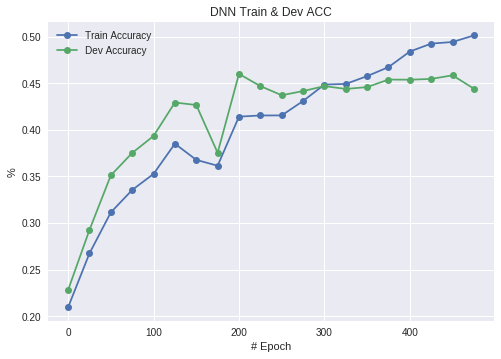

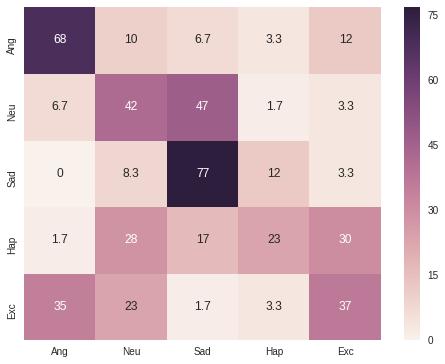

==============[ [4] ]==============
Feature Dimension: 20
Confusion Matrix:
[[68.3 10.   6.7  3.3 11.7]
 [ 6.7 41.7 46.7  1.7  3.3]
 [ 0.   8.3 76.7 11.7  3.3]
 [ 1.7 28.3 16.7 23.3 30. ]
 [35.  23.3  1.7  3.3 36.7]]
Accuracy per classes:
      Ang   Neu   Sad   Hap   Exc
Ang  68.3  10.0   6.7   3.3  11.7
Neu   6.7  41.7  46.7   1.7   3.3
Sad   0.0   8.3  76.7  11.7   3.3
Hap   1.7  28.3  16.7  23.3  30.0
Exc  35.0  23.3   1.7   3.3  36.7
UAR			:	49.33 %
Total Accuracy[ SVM ][ WAR UAR ]
[XX][ [9.86 9.86] ]


In [0]:
ROOT_PATH = '/content/drive'
MODEL_NAME = 'ELM'
nFolders = 5
main(ROOT_PATH, MODEL_NAME, nFolders)

506
Training Deep Neural Network............................
Training CV 4 Deep Neural Network............................
Epoch: 00 		Cost=1.63 	TrainAcc: 0.21 	TestAcc: 0.23
Epoch: 25 		Cost=1.60 	TrainAcc: 0.27 	TestAcc: 0.29
Epoch: 50 		Cost=1.56 	TrainAcc: 0.31 	TestAcc: 0.35
Epoch: 75 		Cost=1.54 	TrainAcc: 0.34 	TestAcc: 0.38
Epoch: 100 		Cost=1.53 	TrainAcc: 0.35 	TestAcc: 0.39
Epoch: 125 		Cost=1.50 	TrainAcc: 0.39 	TestAcc: 0.43
Epoch: 150 		Cost=1.52 	TrainAcc: 0.37 	TestAcc: 0.43
Epoch: 175 		Cost=1.54 	TrainAcc: 0.36 	TestAcc: 0.38
Epoch: 200 		Cost=1.49 	TrainAcc: 0.41 	TestAcc: 0.46
Epoch: 225 		Cost=1.47 	TrainAcc: 0.42 	TestAcc: 0.45
Epoch: 250 		Cost=1.47 	TrainAcc: 0.42 	TestAcc: 0.44
Epoch: 275 		Cost=1.45 	TrainAcc: 0.43 	TestAcc: 0.44
Epoch: 300 		Cost=1.45 	TrainAcc: 0.45 	TestAcc: 0.45
Epoch: 325 		Cost=1.44 	TrainAcc: 0.45 	TestAcc: 0.44
Epoch: 350 		Cost=1.43 	TrainAcc: 0.46 	TestAcc: 0.45
Epoch: 375 		Cost=1.41 	TrainAcc: 0.47 	TestAcc: 0.45
Epoch: 400 		Cost

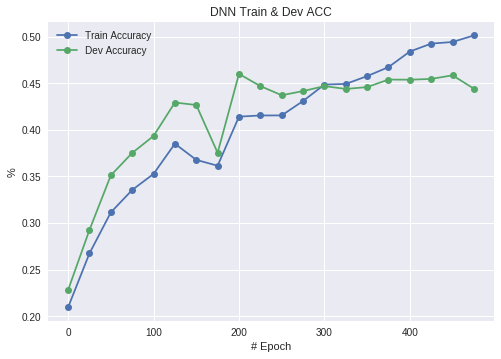

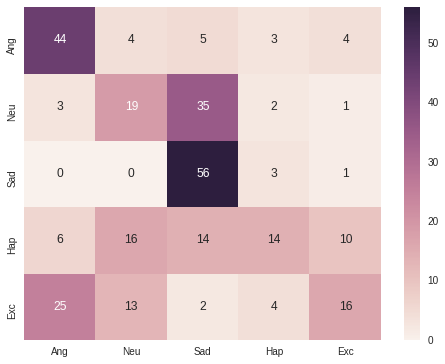

[[44  4  5  3  4]
 [ 3 19 35  2  1]
 [ 0  0 56  3  1]
 [ 6 16 14 14 10]
 [25 13  2  4 16]]
[[73.333  6.667  8.333  5.     6.667]
 [ 5.    31.667 58.333  3.333  1.667]
 [ 0.     0.    93.333  5.     1.667]
 [10.    26.667 23.333 23.333 16.667]
 [41.667 21.667  3.333  6.667 26.667]]
Accuracy per classes:
     Ang  Neu  Sad  Hap  Exc
Ang   44    4    5    3    4
Neu    3   19   35    2    1
Sad    0    0   56    3    1
Hap    6   16   14   14   10
Exc   25   13    2    4   16
UAR			:	49.67 %


In [0]:
from sklearn.ensemble import AdaBoostClassifier
from elm.extreme_learning_machines.extreme_learning_machines import ELMClassifier
from sklearn.utils import shuffle
from collections import Counter


def extract_utterance_level_features(idx, path_save):
    tf.reset_default_graph()    
    tf.set_random_seed(371)
    filename = "%s/CV_0%s/Frame_CV_0%s.pickle"  %(path_save,idx,idx)
    with open(filename, 'rb') as handle:
        data = pickle.load(handle)

    X_Frame_train   = data['X_Frame_train'].astype('float32')
    y_Frame_train   = data['y_Frame_train']
    idx_Frame_train = data['idx_Frame_train']
    X_Frame_test    = data['X_Frame_test'].astype('float32')
    print(sum(idx_Frame_train == 0))
    y_Frame_test    = data['y_Frame_test']
    idx_Frame_test  = data['idx_Frame_test']
    y_train         = data['y_Utter_train']
    y_test          = data['y_Utter_test']

    n_classes=y_test.max()+1
    y_train_onehot=dense_to_one_hot(y_Frame_train,n_classes)
    y_test_onehot=dense_to_one_hot(y_Frame_test,n_classes)


    log ('Training Deep Neural Network............................')
    for d in ['/gpu:%s'%0]:
        with tf.device(d):

            X = tf.placeholder(tf.float32, [None, X_Frame_train.shape[1]])
            Y = tf.placeholder(tf.float32, [None, n_classes])

            weights  = {
                    #he init : stddev=np.sqrt(2 / dim_input)
                    'encoder_h1': tf.Variable(tf.random_normal([X_Frame_train.shape[1], dim_hidden_1],stddev=np.sqrt(2 / X_Frame_train.shape[1]))),
                    'encoder_h2': tf.Variable(tf.random_normal([dim_hidden_1, dim_hidden_2],stddev=np.sqrt(2 / dim_hidden_1))),
                    'encoder_h3': tf.Variable(tf.random_normal([dim_hidden_2, dim_hidden_3],stddev=np.sqrt(2 / dim_hidden_2))),
                    'encoder_output': tf.Variable(tf.random_normal([dim_hidden_3, n_classes],stddev=np.sqrt(2 / dim_hidden_3)))
            }
            biases = {
                    'encoder_b1': tf.Variable(tf.zeros([dim_hidden_1])),
                    'encoder_b2': tf.Variable(tf.zeros([dim_hidden_2])),
                    'encoder_b3': tf.Variable(tf.zeros([dim_hidden_3])),
                    'encoder_output': tf.Variable(tf.zeros([n_classes]))
            }
            

            Z1 = tf.matmul( X, weights['encoder_h1'] ) + biases['encoder_b1']
            l1 = tf.nn.relu(Z1)
            
            i2 = tf.nn.dropout(l1, 0.6)
            Z2 = tf.matmul(i2, weights['encoder_h2']) + biases['encoder_b2']
            l2 = tf.nn.relu(Z2)
            
            i3 = tf.nn.dropout(l2, 0.6)
            Z3 = tf.matmul(i3, weights['encoder_h3']) + biases['encoder_b3']
            l3 = tf.nn.relu(Z3)    

            output       = tf.matmul(l3, weights['encoder_output']) + biases['encoder_output']
            pred         = tf.nn.softmax(output)     

            cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=Y))
            optimizer = tf.train.RMSPropOptimizer(0.01).minimize(cost)
            
            correct_prediction = tf.equal(tf.argmax(pred,1), tf.argmax(Y,1))
            accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.9)
    with tf.Session(config = tf.ConfigProto(allow_soft_placement = True,device_count={'GPU':1},gpu_options=gpu_options)) as sess:
        sess.run(tf.global_variables_initializer())
        log ('Training CV %s Deep Neural Network............................'%idx)
        acc_trn = []
        acc_tst = []
        for epoch in range(training_epoch):
                _, c = sess.run([optimizer,cost], feed_dict = {X: X_Frame_train, Y: y_train_onehot})
                if (epoch % display_step) == 0:
                    train_accuracy=sess.run([accuracy], feed_dict={X: X_Frame_train, Y: y_train_onehot})
                    test_accuracy=sess.run([accuracy], feed_dict={X: X_Frame_test, Y: y_test_onehot})
                    train_pred = sess.run([pred], feed_dict={X: X_Frame_train, Y: y_train_onehot})
                    train_correct_pred = sess.run([correct_prediction], feed_dict={X: X_Frame_train, Y: y_train_onehot})
                    
                    acc_trn.append(train_accuracy)
                    acc_tst.append(test_accuracy)
                    
                    log("Epoch: {:02d} \t\tCost={:.2f} \tTrainAcc: {:.2f} \tTestAcc: {:.2f}".format(epoch,c, train_accuracy[0],test_accuracy[0]))
        global acctrn
        global acctst
        acctrn = acc_trn
        acctst = acc_tst
        
        plt.figure(1)
        plt.plot(range(0,500,25), acctrn, 'o-', label="Train Accuracy")

        plt.plot(range(0,500,25), acctst, 'o-', label="Dev Accuracy")

        plt.xlabel("# Epoch")
        plt.ylabel("%")
        plt.title('DNN Train & Dev ACC')
        plt.legend()

        
        X_Frame_DNN_train = sess.run(pred,feed_dict={X: X_Frame_train})
        #prob_5 = [ sum(x) for x in zip(*my_list) ]
        global exp
        exp = X_Frame_DNN_train[:157]
        
        X_Frame_DNN_test  = sess.run(pred,feed_dict={X: X_Frame_test})   


    #X_Frame_DNN_train,X_Frame_DNN_test=normalize_Zscore(X_Frame_DNN_train,X_Frame_DNN_test)

    utterFeatList = []
    for i in range(idx_Frame_train.max() + 1):
        
        frames = X_Frame_DNN_train[idx_Frame_train == i, :]
        if frames.size != 0:
            utter_feat = np.hstack([np.amax(frames, axis=0), np.amin(frames, axis=0), np.mean(frames, axis=0), np.mean(frames > 0.2, axis=0) ])
            utterFeatList.append(utter_feat)

        X_train = np.vstack(utterFeatList)

#     print(f'X_Frame_DNN: {X_Frame_DNN_train}')
#     print(f'Utterance Feature: {utterFeatList}')
    utterFeatList_test = []
    for i in range(idx_Frame_test.max() + 1):
        frames = X_Frame_DNN_test[idx_Frame_test == i, :]
        if frames.size != 0:
            utter_feat = np.hstack([np.amax(frames, axis=0), np.amin(frames, axis=0), np.mean(frames, axis=0), np.mean(frames > 0.2, axis=0) ])
            utterFeatList_test.append(utter_feat)
        X_test = np.vstack(utterFeatList_test)
    log("Utterance-Level-Features are extracted.")

    log ("Classifying Speech Emotions using Utter-Level features............................")

    """Extreme Learning Machine"""
    





    """Extreme Learning Machine"""


    elm = ELMClassifier(n_hidden=300)
    ada = AdaBoostClassifier(base_estimator=elm, n_estimators=350)

    ada.fit(X_train, y_train)
    y_pred = ada.predict(X_test)

    uar = 0

    cnf_matrix = confusion_matrix(y_test, y_pred)
    diag = np.diagonal(cnf_matrix)
    for index, i in enumerate(diag):
        uar += i / Counter(y_test)[index]
    test_unweighted_accuracy = uar / len(cnf_matrix)
    # test_weighted_accuracy = np.sum(y_test == y_pred) / len(y_pred)
    accuracy = []
    # accuracy.append(test_weighted_accuracy * 100)
    accuracy.append(test_unweighted_accuracy * 100)

    a = ['Ang', 'Neu', 'Sad', 'Hap', 'Exc']
    # Compute confusion matrix
    cnf_matrix_acc = np.transpose(cnf_matrix)
    cnf_matrix_acc = cnf_matrix_acc * 100 / cnf_matrix_acc.astype(np.int).sum(axis=0)
    cnf_matrix_acc = np.transpose(cnf_matrix_acc).astype(float)
    cnf_matrix_acc = np.around(cnf_matrix_acc, decimals=3)
    
    

    #accuracy per class
    conf_mat = (cnf_matrix_acc.diagonal() * 100)/cnf_matrix_acc.sum(axis=1)
    conf_mat = np.around(conf_mat, decimals=2)
    conf_mat = pd.DataFrame(cnf_matrix_acc, index = a, columns = a)

    plt.figure(2)
    sn.heatmap(conf_mat, annot=True)
    plt.subplots_adjust(bottom=0.08, top=0.92)
    plt.show()
    
    print(cnf_matrix)
    print(cnf_matrix_acc)
    print('Accuracy per classes:\n%s'%conf_mat)
    print("UAR\t\t\t:\t%.2f %%" %(test_unweighted_accuracy * 100))

    return cnf_matrix, cnf_matrix_acc, np.around(np.array(accuracy), decimals=2)



def main(nFolders):

    DATA_PATH = '/content/drive/datasets/IEMOCAP/ELM'
    
#     acc_stat1 = np.zeros(2)
    
    cnf_matrix, cnf_matrix_acc, acc_stat1 = extract_utterance_level_features(4, DATA_PATH)
    
    
#     for idx in range(nFolders):
#         acc_stat1 += ada_elm(idx, DATA_PATH)

#     N_HIDDEN_ELM = list(range(600, 1000, 50))
#     ADA_N_ESTIMATORS = list(range(700, 1400, 50))


#     for i in N_HIDDEN_ELM:
#         for j in ADA_N_ESTIMATORS:
#             acc_stat1 = ada_elm(2, DATA_PATH, i, j)
#             accs.append(acc_stat1)
#             print(f'{i},{j},{acc_stat1}')
#             print()

#     accuracys = np.array(accs)
#     print(np.max(accuracys))
#     print(np.argmax(accuracys))

#     print('[XX][ %s ]'%(acc_stat1 / nFolders))

    
nFolders = 5
ROOT_PATH = '/content/drive'
MODEL_NAME = 'ELM'
main(nFolders)
    
    
    
    
    
   

In [0]:
seg_prob = [[73.333,  6.667,  8.333,  5.,    6.667],
 [ 5.,    31.667, 58.333,  3.333,  1.667],
 [ 0. ,    0. ,   93.333 , 5. ,    1.667],
 [10. ,   26.667, 23.333, 23.333, 16.667],
 [41.667, 21.667,  3.333 , 6.667, 26.667]]

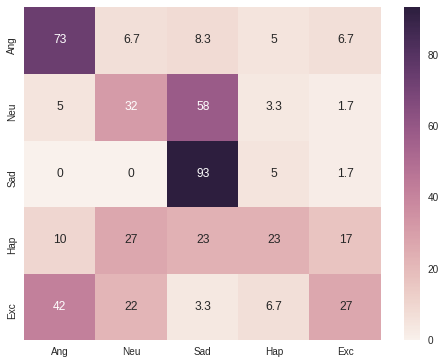

In [0]:
a = ['Ang', 'Neu', 'Sad', 'Hap', 'Exc']
conf_mat = pd.DataFrame(seg_prob, index = a, columns = a)

plt.figure(2)
sn.heatmap(conf_mat, annot=True)
plt.subplots_adjust(bottom=0.08, top=0.92)
plt.show()
    

In [0]:
b = np.array(seg_prob)
b[:,0]

array([3.83310922e-04, 1.22126105e-04, 5.63774811e-05, 1.79226234e-04,
       1.84126408e-03, 1.44099863e-03, 2.51064282e-02, 1.03467489e-02,
       1.50196888e-02, 2.29812711e-02, 6.16315287e-03, 1.16501283e-02,
       3.98601256e-02, 3.17916721e-02, 1.64146572e-02, 3.05325235e-03,
       9.44023207e-02, 1.40109509e-01, 1.06139548e-01, 1.33220106e-01,
       3.85704845e-01, 9.49293301e-02, 8.29109550e-02, 6.46797866e-02,
       5.50838448e-02, 1.16815254e-01, 4.55299132e-02, 3.58830899e-01,
       7.01201260e-01, 8.10958266e-01, 8.85398388e-01, 7.53333271e-01,
       7.48349011e-01, 7.10915267e-01, 7.95226038e-01, 8.04583967e-01,
       3.26898366e-01, 6.60675406e-01, 7.54732788e-01, 9.03740704e-01,
       8.91075969e-01, 4.25930232e-01, 3.08748811e-01, 4.84027475e-01,
       2.25263566e-01, 5.11820555e-01, 4.48247075e-01, 1.96925521e-01,
       2.52660662e-01, 2.10317448e-01, 4.18151587e-01, 1.85607553e-01,
       4.88055229e-01, 3.02227646e-01, 1.63465664e-01, 4.60708946e-01,
      

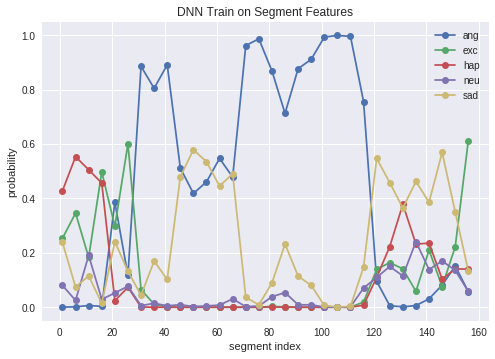

In [0]:
plt.plot(range(1,158,5), ang[::5], 'o-', label="ang")
plt.plot(range(1,158,5), exc[::5], 'o-', label="exc")
plt.plot(range(1,158,5), hap[::5], 'o-', label="hap")
plt.plot(range(1,158,5), neu[::5], 'o-', label="neu")
plt.plot(range(1,158,5), sad[::5], 'o-', label="sad")
plt.xlabel("segment index")
plt.ylabel("probability")
plt.title('DNN Train on Segment Features')
plt.legend()
plt.show()

In [0]:
len(acctrn)

10

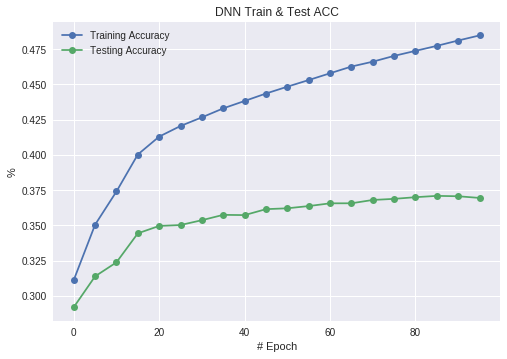

In [0]:
plt.plot(range(0,100,5), acctrn, 'o-', label="Training Accuracy")

plt.plot(range(0,100,5), acctst, 'o-', label="Testing Accuracy")

plt.xlabel("# Epoch")
plt.ylabel("%")
plt.title('DNN Train & Test ACC')
plt.legend()
plt.show()